In [1]:
import tensorboard

In [2]:
import tensorflow as tf
tf.enable_eager_execution()
import tempfile
import zipfile
import os

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import zipfile
import os

print(tf.__version__)

fashion_mnist = keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

batch_size = 128
num_classes = 10
epochs = 7

img_rows, img_cols = 28, 28

if tf.keras.backend.image_data_format() == 'channels_first':
  x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
  x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
  input_shape = (1, img_rows, img_cols)
else:
  x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
  x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
  input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


1.14.1-dev20190516
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


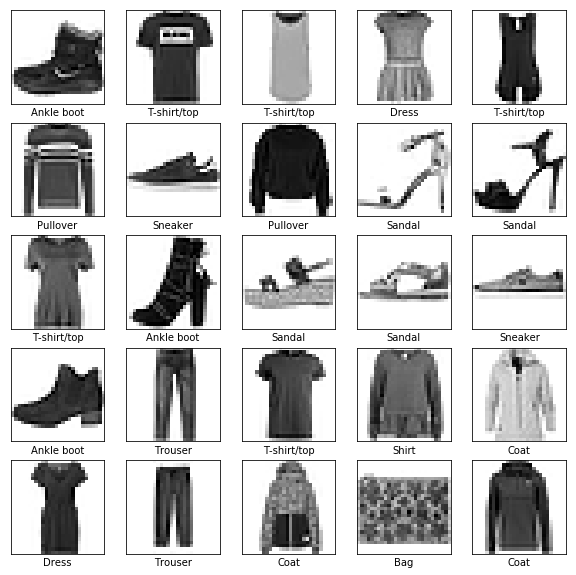

In [4]:
num_classes=10
y_train1 = tf.keras.utils.to_categorical(y_train, num_classes)
y_test1 = tf.keras.utils.to_categorical(y_test, num_classes)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train.reshape(-1,28,28)[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [5]:
l = tf.keras.layers

model = tf.keras.Sequential([
    l.Conv2D(
        32, 5, padding='same', activation='relu', input_shape=input_shape),
    l.MaxPooling2D((2, 2), (2, 2), padding='same'),
    l.BatchNormalization(),
    l.Conv2D(64, 5, padding='same', activation='relu'),
    l.MaxPooling2D((2, 2), (2, 2), padding='same'),
    l.Flatten(),
    l.Dense(1024, activation='relu'),
    l.Dropout(0.4),
    l.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3

In [28]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir="/home/rubens/anaconda3/logs", profile_batch=0)]

model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=callbacks,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/7
60000/60000 [==============================] - 94s 2ms/sample - loss: 0.4186 - accuracy: 0.8507 - val_loss: 0.9104 - val_accuracy: 0.8853
Epoch 2/7
60000/60000 [==============================] - 93s 2ms/sample - loss: 0.2673 - accuracy: 0.9023 - val_loss: 0.2762 - val_accuracy: 0.8956
Epoch 3/7
60000/60000 [==============================] - 98s 2ms/sample - loss: 0.2231 - accuracy: 0.9173 - val_loss: 0.2435 - val_accuracy: 0.9091
Epoch 4/7
60000/60000 [==============================] - 94s 2ms/sample - loss: 0.1941 - accuracy: 0.9280 - val_loss: 0.2567 - val_accuracy: 0.9071
Epoch 5/7
60000/60000 [==============================] - 95s 2ms/sample - loss: 0.1725 - accuracy: 0.9354 - val_loss: 0.2461 - val_accuracy: 0.9108
Epoch 6/7
60000/60000 [==============================] - 88s 1ms/sample - loss: 0.1453 - accuracy: 0.9452 - val_loss: 0.2597 - val_accuracy: 0.9053
Epoch 7/7
60000/60000 [==============================] - 87s 1

In [29]:
_, keras_file = tempfile.mkstemp('.h5')
print('Saving model to: ', keras_file)
tf.keras.models.save_model(model, keras_file, include_optimizer=False)

Saving model to:  /tmp/tmpgztdnyvh.h5


In [6]:
from tensorflow_model_optimization.sparsity import keras as sparsity
import numpy as np

epochs = 7
num_train_samples = x_train.shape[0]
end_step = 7
print('End step: ' + str(end_step))

End step: 7


In [7]:
#! pip install -U tf-nightly-gpu

In [9]:
pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=3,
                                                   end_step=end_step,
                                                   frequency=100)
}

pruned_model = tf.keras.Sequential([
    sparsity.prune_low_magnitude(
        l.Conv2D(32, 5, padding='same', activation='relu'),
        input_shape=input_shape,
        **pruning_params),
    l.MaxPooling2D((2, 2), (2, 2), padding='same'),
    l.BatchNormalization(),
    sparsity.prune_low_magnitude(
        l.Conv2D(64, 5, padding='same', activation='relu'), **pruning_params),
    l.MaxPooling2D((2, 2), (2, 2), padding='same'),
    l.Flatten(),
    sparsity.prune_low_magnitude(l.Dense(1024, activation='relu'),
                                 **pruning_params),
    l.Dropout(0.4),
    sparsity.prune_low_magnitude(l.Dense(num_classes, activation='softmax'),
                                 **pruning_params)
])

pruned_model.summary()

W0516 16:19:09.095824 140032309667584 deprecation.py:323] From /home/rubens/anaconda3/lib/python3.6/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_schedule.py:240: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d_2 (None, 28, 28, 32)        1634      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
prune_low_magnitude_conv2d_3 (None, 14, 14, 64)        102466    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
prune_low_magnitude_dense_2  (None, 1024)             

In [11]:
pruned_model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
callbacks = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir="/home/rubens/anaconda3/logs2", profile_batch=0)
]

pruned_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          callbacks=callbacks,
          validation_data=(x_test, y_test))

score = pruned_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 106s 2ms/sample - loss: 0.4562 - acc: 0.8403 - val_loss: 0.6507 - val_acc: 0.8785
Epoch 2/10
60000/60000 [==============================] - 102s 2ms/sample - loss: 0.2732 - acc: 0.8990 - val_loss: 0.2708 - val_acc: 0.8971
Epoch 3/10
60000/60000 [==============================] - 105s 2ms/sample - loss: 0.2305 - acc: 0.9148 - val_loss: 0.2430 - val_acc: 0.9106
Epoch 4/10
60000/60000 [==============================] - 106s 2ms/sample - loss: 0.1957 - acc: 0.9273 - val_loss: 0.2472 - val_acc: 0.9136
Epoch 5/10
60000/60000 [==============================] - 95s 2ms/sample - loss: 0.1741 - acc: 0.9356 - val_loss: 0.2575 - val_acc: 0.9091
Epoch 6/10
60000/60000 [==============================] - 98s 2ms/sample - loss: 0.1534 - acc: 0.9427 - val_loss: 0.2340 - val_acc: 0.9162
Epoch 7/10
60000/60000 [==============================] - 95s 2ms/sample - loss: 0.1316 - acc: 0.9508 - val_loss

In [12]:
_, checkpoint_file = tempfile.mkstemp('.h5')
print('Saving pruned model to: ', checkpoint_file)
# saved_model() sets include_optimizer to True by default. Spelling it out here
# to highlight.
tf.keras.models.save_model(pruned_model, checkpoint_file, include_optimizer=True)

with sparsity.prune_scope():
  restored_model = tf.keras.models.load_model(checkpoint_file)

restored_model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=2,
                   verbose=1,
                   callbacks=callbacks,
                   validation_data=(x_test, y_test))

score = restored_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Saving pruned model to:  /tmp/tmpz7h7bwil.h5
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 90s 1ms/sample - loss: 0.0765 - acc: 0.9719 - val_loss: 0.2924 - val_acc: 0.9189
Epoch 2/2
60000/60000 [==============================] - 87s 1ms/sample - loss: 0.0676 - acc: 0.9748 - val_loss: 0.3062 - val_acc: 0.9234
Test loss: 0.3061785455726087
Test accuracy: 0.9234


In [13]:
final_model = sparsity.strip_pruning(pruned_model)
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)             

In [14]:
_, pruned_keras_file = tempfile.mkstemp('.h5')
print('Saving pruned model to: ', pruned_keras_file)

# No need to save the optimizer with the graph for serving.
tf.keras.models.save_model(final_model, pruned_keras_file, include_optimizer=False)

Saving pruned model to:  /tmp/tmp6x9qn6d2.h5


In [16]:
_, zip1 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(checkpoint_file)
print("Size of the unpruned model before compression: %.2f Mb" % 
      (os.path.getsize(checkpoint_file) / float(2**20)))
print("Size of the unpruned model after compression: %.2f Mb" % 
      (os.path.getsize(zip1) / float(2**20)))

_, zip2 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip2, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(pruned_keras_file)
print("Size of the pruned model before compression: %.2f Mb" % 
      (os.path.getsize(pruned_keras_file) / float(2**20)))
print("Size of the pruned model after compression: %.2f Mb" % 
      (os.path.getsize(zip2) / float(2**20)))

Size of the unpruned model before compression: 50.02 Mb
Size of the unpruned model after compression: 31.61 Mb
Size of the pruned model before compression: 12.52 Mb
Size of the pruned model after compression: 7.24 Mb


In [22]:
#tensorboard --logdir="/home/rubens/anaconda3/logs2" --host=127.0.0.1